In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnninterpreter import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

import torch
from torch import nn
import torch_geometric as pyg
from torchmetrics import F1Score

# Mutag

In [13]:
mutag = MUTAGDataset(seed=12345)
k_fold = 10
train_data = mutag[len(mutag)//k_fold:]
val_data = mutag[:len(mutag)//k_fold]
train_loader = pyg.loader.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = pyg.loader.DataLoader(val_data, batch_size=32, shuffle=False)
all_loader = pyg.loader.DataLoader(mutag, batch_size=32, shuffle=False)

In [6]:
mutag.describe()

{'mean_n': 17.930851063829788,
 'mean_m': 19.79255319148936,
 'std_n': 4.575664737098715,
 'std_m': 5.684483160355228}

# Train Model

In [7]:
model = GNNClassifier(hidden_channels=64,
                      node_features=len(mutag.NODE_CLS),
                      num_classes=len(mutag.GRAPH_CLS))
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [8]:
def train():
    model.train()
    losses = []
    for batch in tqdm(train_loader, position=1, leave=False, disable=True):
        model.zero_grad()  # Clear gradients.
        out = model(batch)  # Perform a single forward pass.
        loss = criterion(out['logits'], batch.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def test(loader):
    f1 = F1Score(task="multiclass", num_classes=len(mutag.GRAPH_CLS), average=None)
    model.eval()
    for batch in tqdm(loader, position=1, leave=False, disable=True):
        f1(model(batch)['logits'], batch.y)
    return dict(zip(mutag.GRAPH_CLS.values(), f1.compute().tolist()))

@torch.no_grad()
def gt_score():
    batch = pyg.data.Batch.from_data_list([mutag.motifs[1]])
    neg, pos = model(batch).mean(dim=0).numpy()
    return neg, pos

In [ ]:
for epoch in trange(128, position=0, leave=True, disable=True):
    train_loss = train()
    train_acc = test(train_loader)
    test_acc = test(val_loader)
    # neg, pos = gt_score()
    print(
        f'Epoch: {epoch:03d}, '
        f'Train Loss: {train_loss:.4f}, '
        f'Train Acc: {train_acc}, '
        f'Test Acc: {test_acc}, '
        # f'GT Pos Score: {pos:.4f}, '
        # f'GT Neg Score: {neg:.4f}, '
    )

Epoch: 000, Train Loss: 1.2749, Train Acc: {'random': 0.34185463190078735, 'lollipop': 0.08935974538326263, 'wheel': 0.8567175269126892, 'grid': 0.49056604504585266, 'star': 0.9532010555267334}, Test Acc: {'random': 0.2590673565864563, 'lollipop': 0.05907173082232475, 'wheel': 0.8856304883956909, 'grid': 0.49070632457733154, 'star': 0.962199330329895}, 
Epoch: 001, Train Loss: 0.7152, Train Acc: {'random': 0.6875210404396057, 'lollipop': 0.08843187987804413, 'wheel': 0.9398385882377625, 'grid': 0.5603621602058411, 'star': 0.9942445755004883}, Test Acc: {'random': 0.6578947305679321, 'lollipop': 0.08372092992067337, 'wheel': 0.945868968963623, 'grid': 0.5581395626068115, 'star': 0.9933333396911621}, 
Epoch: 002, Train Loss: 0.6276, Train Acc: {'random': 0.6162821650505066, 'lollipop': 0.4423440396785736, 'wheel': 0.9380764365196228, 'grid': 0.44609665870666504, 'star': 1.0}, Test Acc: {'random': 0.6025974154472351, 'lollipop': 0.4041095972061157, 'wheel': 0.9551451206207275, 'grid': 0.4

In [10]:
# torch.save(model.state_dict(), 'shape_gnn_64x4.pt')
model.load_state_dict(torch.load('mutag_gnn_64x3.pt'))

<All keys matched successfully>

In [14]:
test(train_loader)

{'nonmutagen': 0.8928571343421936, 'mutagen': 0.9473684430122375}

In [15]:
test(val_loader)

{'nonmutagen': 0.7692307829856873, 'mutagen': 0.8695651888847351}

# Generate Average Embedding

In [16]:
embeds = [[] for _ in range(len(mutag.GRAPH_CLS))]
with torch.no_grad():
    for data in tqdm(mutag):
        embeds[data.y.item()].append(model.eval()(pyg.data.Batch.from_data_list([data]))["embeds"].numpy())
mean_embeds = [torch.tensor(np.concatenate(e).mean(axis=0)) for e in embeds]

  0%|          | 0/188 [00:00<?, ?it/s]

In [17]:
trainer = {}
sampler = {}

# 1

In [24]:
classes = 1
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_node_cls=len(mutag.NODE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=10),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=1), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=0), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                  discriminator=model,
                  criterion=criterion,
                  optimizer=optimizer,
                  scheduler=scheduler,
                  dataset=mutag,
                  k_samples=16)

In [25]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9


In [26]:
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 20
    ])

In [27]:
trainer[1].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=16 m=14
logits=[-189.2996826171875, 188.76339721679688]
probs=[0.0, 1.0]


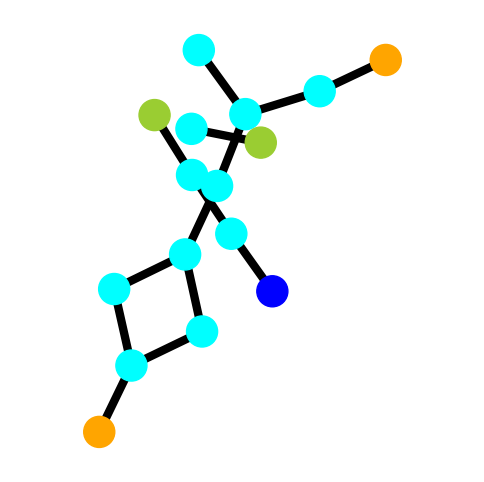

In [28]:
G = trainer[classes].evaluate(threshold=0.5, show=True)
plt.show()

# 0

In [29]:
classes = 0
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_node_cls=len(mutag.NODE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=10),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=1), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=0), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=mutag,
                           k_samples=16)

In [30]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9


In [31]:
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 20
    ])

In [33]:
trainer[0].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=18 m=20
logits=[717.5263671875, -784.9716186523438]
probs=[1.0, 0.0]


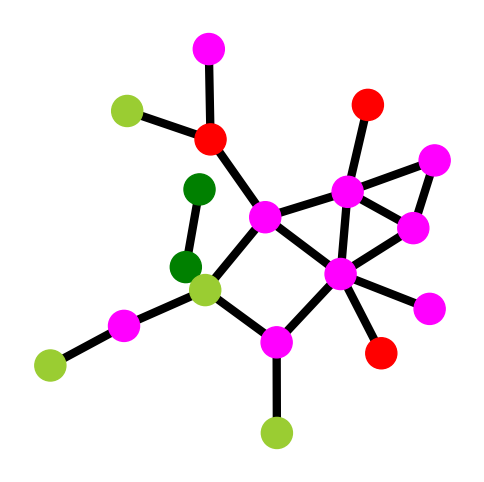

In [35]:
trainer[0].evaluate(threshold=0.5, show=True)

n=18 m=21
logits=[692.9840698242188, -758.0659790039062]
probs=[1.0, 0.0]


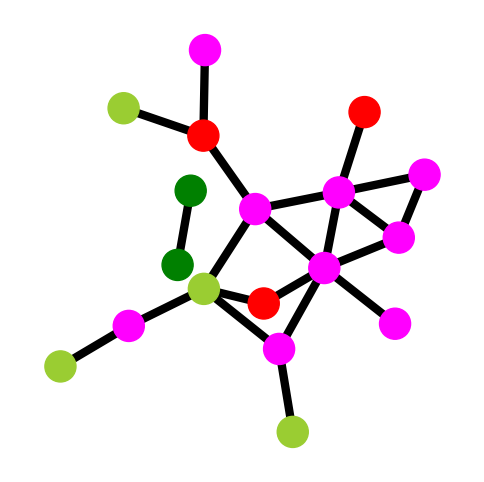

In [36]:
trainer[0].evaluate(bernoulli=True, show=True)